In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
from texttable import Texttable
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LSTM, TimeDistributed, Reshape,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from keras.initializers import glorot_uniform
from keras.initializers import Orthogonal

In [2]:
pip install Texttable

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Chemin vers les dossiers de données
train_dir = '/content/drive/My Drive/chest_xray/train'
val_dir = '/content/drive/My Drive/chest_xray/val'
test_dir = '/content/drive/My Drive/chest_xray/test'

In [6]:

def count_images(directory_path, categories):
    """
    Counts the number of images in specific subfolders for each category.

    :param directory_path: The base directory path containing category subfolders.
    :param categories: A list of category names (subfolder names).
    :return: A dictionary with category names as keys and image counts as values.
    """
    counts = {}
    for category in categories:
        path = os.path.join(directory_path, category)
        try:
            counts[category] = len(os.listdir(path))
        except FileNotFoundError:
            counts[category] = 0  # Handle missing category directories gracefully
    return counts

# Paths to your training, testing, and validation directories
directories = {
    'Training': '/content/drive/My Drive/chest_xray/train',
    'Test': '/content/drive/My Drive/chest_xray/test',
    'Validation': '/content/drive/My Drive/chest_xray/val'  # Ensure this path exists if you have a validation folder
}

categories = ['NORMAL', 'PNEUMONIA']

# Use the count_images function to get the number of images
dataset_counts = {dtype: count_images(dir_path, categories) for dtype, dir_path in directories.items()}

# Creating and displaying the table
t = Texttable()
header = ['Dataset Type'] + categories
t.add_row(header)
for dtype, counts in dataset_counts.items():
    row = [dtype] + [counts[category] for category in categories]
    t.add_row(row)

print(t.draw())


+--------------+--------+-----------+
| Dataset Type | NORMAL | PNEUMONIA |
+--------------+--------+-----------+
| Training     | 1342   | 1521      |
+--------------+--------+-----------+
| Test         | 234    | 390       |
+--------------+--------+-----------+
| Validation   | 8      | 8         |
+--------------+--------+-----------+


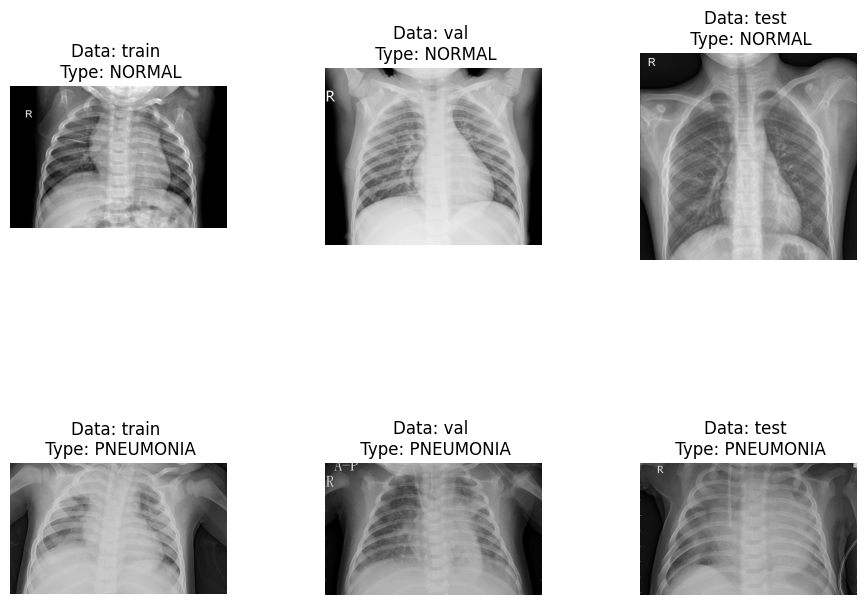

In [7]:
DATA_DIR = '/content/drive/My Drive/chest_xray'  # Ensure this is your correct base directory

# Preparing the figure for plotting
fig, ax = plt.subplots(2, 3, figsize=(10, 8))  # 2 rows for Normal and Pneumonia, 3 columns for train, val, test
ax = ax.ravel()
plt.tight_layout(pad=4.0)  # Adjust spacing between plots

# Enumerating through dataset types to display one image from each class
for i, dataset_type in enumerate(['train', 'val', 'test']):
    for j, condition in enumerate(['NORMAL', 'PNEUMONIA']):
        # Constructing the path for the first image in each category
        image_path = os.path.join(DATA_DIR, dataset_type, condition)
        image_file = os.listdir(image_path)[0]  # Assuming there's at least one image
        image_full_path = os.path.join(image_path, image_file)

        # Plotting
        ax[i + j*3].imshow(plt.imread(image_full_path), cmap='gray')
        ax[i + j*3].set_title(f'Data: {dataset_type} \n Type: {condition}', fontsize=12)
        ax[i + j*3].axis('off')  # Hide axes for clarity

plt.show()

In [8]:
# Constants for data preprocessing
DETECTION_CLASSES = ['NORMAL', 'PNEUMONIA']
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)  # Standard for many CNNs like VGG16, ResNet, etc.

In [18]:
# Image dimensions
img_height, img_width = 150, 150  # Example dimensions, modify according to your data
num_channels = 3  # RGB images have 3 channels
num_classes = 2  # Example for binary classification, modify according to your data

# Data generators with augmentation for training and only rescaling for validation/test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Assuming you have similar augmentations for the test data if not remove or adjust accordingly
test_datagen = ImageDataGenerator(
    rescale=1./255
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'  # Use 'categorical' for multi-class classification
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'  # Use 'categorical' for multi-class classification
)

Found 2862 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
batch_size=32
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # Use 'softmax' if you have more than two classes
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 17, 17, 128)      

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Assuming 'train_generator' and 'validation_generator' are defined and initialized
# Add checks to ensure 'train_generator.samples' and 'validation_generator.samples' are correct
print("Training samples:", train_generator.samples)
print("Validation samples:", validation_generator.samples)
print("Batch size:", batch_size)

if train_generator.samples == 0:
    raise ValueError("Found 0 images in training directory.")

if validation_generator.samples == 0:
    raise ValueError("Found 0 images in validation directory.")

# Define the batch size
batch_size = 32  # This should be a number that divides your total number of images

# Check if 'steps_per_epoch' and 'validation_steps' are greater than 0
steps_per_epoch = max(1, train_generator.samples // batch_size)
validation_steps = max(1, validation_generator.samples // batch_size)

# Continue with the training process if no issues
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps
)


Training samples: 2862
Validation samples: 16
Batch size: 32
Epoch 1/10
89/89 [==============================] - 260s 3s/step - loss: 0.6685 - accuracy: 0.6459 - val_loss: 0.7543 - val_accuracy: 0.5625
Epoch 2/10
89/89 [==============================] - 231s 3s/step - loss: 0.4480 - accuracy: 0.8102 - val_loss: 0.4853 - val_accuracy: 0.8125
Epoch 3/10
89/89 [==============================] - 223s 2s/step - loss: 0.3433 - accuracy: 0.8580 - val_loss: 0.3898 - val_accuracy: 0.8750
Epoch 4/10
89/89 [==============================] - 232s 3s/step - loss: 0.3382 - accuracy: 0.8664 - val_loss: 0.6453 - val_accuracy: 0.7500
Epoch 5/10
89/89 [==============================] - 223s 3s/step - loss: 0.3128 - accuracy: 0.8802 - val_loss: 0.3548 - val_accuracy: 0.8125
Epoch 6/10
89/89 [==============================] - 221s 2s/step - loss: 0.3010 - accuracy: 0.8806 - val_loss: 0.3663 - val_accuracy: 0.8125
Epoch 7/10
89/89 [==============================] - 230s 3s/step - loss: 0.2731 - accuracy: 0

In [24]:
# Evaluate the model on the test data
eval_result = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")


19/19 [==============================] - 4s 243ms/step - loss: 0.4906 - accuracy: 0.9474
Test Loss: 0.4906098246574402, Test Accuracy: 0.9473684430122375


624/624 [==============================] - 140s 224ms/step


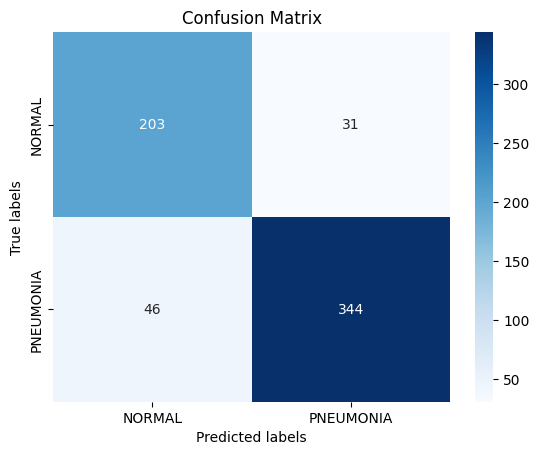

In [26]:
# Predict the labels for the test data
test_predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert the probabilities to class labels
test_predicted_classes = (test_predictions > 0.5).astype(int).flatten()

# Retrieve the true class labels
test_true_classes = test_generator.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_predicted_classes)

# Display the confusion matrix using Seaborn's heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)

# Labels, title and ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [36]:
MODEL_LOC = '/content/drive/My Drive/chest_xray/my_model_final_2_kafia.h5'
model_weights = history.model.save_weights(MODEL_LOC)


In [29]:
# Save the trained model to a specific directory
model.save('/content/drive/My Drive/chest_xray/my_model_final_kafia.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
# Load the trained model
model_path = '/content/drive/My Drive/chest_xray/my_model_final_kafia.h5'
model = load_model(model_path)

In [31]:
# Load the trained model
from tensorflow.keras.models import load_model

# Prepare your test data (assuming you already have 'test_generator' defined)
# Make sure that 'test_generator' is properly configured to load your test images

# Use the model to make predictions on the test data
# Predict the probabilities for each class
test_predictions = model.predict(test_generator)

# Convert the probabilities to class labels
test_predicted_classes = (test_predictions > 0.5).astype(int).flatten()

# Retrieve the true class labels
test_true_classes = test_generator.classes

# Evaluate the predictions
from sklearn.metrics import classification_report

# Generate a classification report
print(classification_report(test_true_classes, test_predicted_classes))

# Calculate accuracy
accuracy = (test_true_classes == test_predicted_classes).mean()
print(f"Accuracy: {accuracy}")


624/624 [==============================] - 32s 52ms/step
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       234
           1       0.92      0.88      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624

Accuracy: 0.8766025641025641


In [48]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your model
model_path = '/content/drive/My Drive/chest_xray/my_model_final_kafia.h5'# Update with the path to your model
model = load_model(model_path)

# Load and preprocess the image
def preprocess_image(image_path):
    try:
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError("Unable to load image. Please check the image path.")

        # Resize the image to match the input shape of your model
        image = cv2.resize(image, (150, 150))
        # Convert the image to the format expected by your model (e.g., RGB or BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Normalize the pixel values to the range [0, 1]
        image = image / 255.0
        # Expand the dimensions of the image to match the input shape of your model
        image = np.expand_dims(image, axis=0)
        return image
    except Exception as e:
        print("Error:", e)
        return None

# Define the path to the test image
image_path = '/content/drive/My Drive/chest_xray/test/PNEUMONIA/person80_bacteria_390.jpeg'  # Update with the path to your test image

# Preprocess the test image
preprocessed_image = preprocess_image(image_path)

if preprocessed_image is not None:
    # Perform the prediction
    prediction = model.predict(preprocessed_image)
    # Convert the prediction to a human-readable format
    if prediction[0] > 0.5:
        print("The image is predicted to be Pneunomonia.")
    else:
        print("The image is predicted to be normal.")


1/1 [==============================] - 0s 124ms/step
The image is predicted to be Pneunomonia.
